In [ ]:

#Importing Libraries
import numpy as np
import keras.backend as K
import tensorflow as tf
import operator
from tensorflow import keras
from keras.utils import np_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd

In [ ]:
import os
import pickle
import time

In [ ]:

if not os.path.isfile( corpus_text_file ):
    if not os.path.exists(corpus_dir):
        os.makedirs(corpus_dir)

    corpus_text_tar = 'eng_wikipedia_2010_100K.tar.gz'
    download_url = 'http://pcai056.informatik.uni-leipzig.de/downloads/corpora/'+corpus_text_tar

    data_cache = './data/cache'
    if not os.path.exists(data_cache):
        os.makedirs(data_cache)

    import shutil, requests

    tarfilepath = os.path.join(data_cache, corpus_text_tar)
    if not os.path.isfile( tarfilepath ):
        response = requests.get(download_url)
        with open(tarfilepath, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    if os.path.isfile(tarfilepath):
        import tarfile
        tarfile.open(tarfilepath, 'r:gz').extractall(corpus_dir)
        # tarfile.open(tarfilepath, 'r:gz').extract('eng_wikipedia_2010_100K-sentences.txt', corpus_dir)
    shutil.move(os.path.join(corpus_dir, 'eng_wikipedia_2010_100K-sentences.txt'), corpus_text_file)

    # Get rid of tarfile source (the required text file itself will remain)
    os.unlink(tarfilepath)

print("Corpus available locally")


NameError: ignored

In [ ]:
corpus_dir = './data/RNN/'
corpus_text_file = "/content/data/RNN/eng_wikipedia_2010_300K-sentences.txt"
# corpus_text_file = "/content/drive/MyDrive/Colab Notebooks/eng_wikipedia_2010_100K-sentences.txt"
def corpus_sentence_tokens(corpus_text_file=corpus_text_file):
  corpus = []
  with open(corpus_text_file, encoding='utf-8') as f:
    for line in f.readlines():
      # print(line)
      # break
      words = line.split('\t')
      word = words[1].strip()
      corpus.append(word)
  return corpus
# corpus_sentence_tokens()

In [ ]:

corpus = corpus_sentence_tokens()
print("Number of sentences:", len(corpus))
MAX_SENTENCES = 2000
corpus = corpus[:MAX_SENTENCES]

# Remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# Convert text to sequence of integer values
# print(corpus[0:10])
corpus = tokenizer.texts_to_sequences(corpus)
# print(corpus[0:10])

# Total number of words in the corpus
samples = sum(len(s) for s in corpus)
print("Total Number of Words in Corpus:", samples)

# Total number of unique words in the corpus
U = len(tokenizer.word_index) + 1
print("Number of Unique Words:", U-1)


Number of sentences: 300000
Total Number of Words in Corpus: 40407
Number of Unique Words: 10202


In [ ]:
# Parameters
window_size = 2



#CBOW Word encoding
from keras.preprocessing import sequence
'''
['He', 'is', 'a', 'good', 'boy']
'a'
['is', 'a'], ['good', 'a'] ['boy', 'a']['he', 'a']  -->skip gram encoding
['he', 'is', 'good', 'boy'] --> cbow encoding
'''
# Prepare the data for the CBOW model
def generate_data_cbow(corpus, window_size, U):
    all_in = []
    all_out = []

    # Iterate over all sentences
    for sentence in corpus:
        L = len(sentence)
        #print(L)
        for index, word in enumerate(sentence):
            start = index - window_size
            end = index + window_size + 1

            # Empty list which will store the context words
            context_words = []
            for i in range(start, end):
                # Skip the 'same' word
                if i != index:
                    # Add a word as a context word if it is within the window size
                    if 0 <= i < L:
                        context_words.append(sentence[i])
                    else:
                        # Pad with zero if there are no words
                        context_words.append(0)
            # Append the list with context words
            all_in.append(context_words)

            # Add one-hot encoding of the target word
            all_out.append(to_categorical(word, U))

    return (np.array(all_in), np.array(all_out))


In [ ]:
# Create the training data
X_cbow, y_cbow = generate_data_cbow(corpus, window_size, U)
#print('X_cbow = ', X_cbow,' \n y_cbow = ', y_cbow)
# I am a good boy
# Create the CBOW architecture
dim = 150

cbow = Sequential()
    # Adding different layers
cbow.add(Embedding(input_dim = U, output_dim=dim, input_length=window_size*2, # Note that we now have 2L words for each input entry
                   embeddings_initializer='glorot_uniform'))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim, )))   # outputs: 20 dimensional vector
cbow.add(Dense(U, activation='softmax', kernel_initializer='glorot_uniform'))  #20 dimensional vector --> Final Word.
cbow.compile(optimizer=keras.optimizers.Adam(learning_rate = .1),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
cbow.summary()


# Train CBOW model
# for cbow in cbow_models:
cbow.fit(X_cbow, y_cbow, batch_size=100, epochs=40, verbose=1)

weights = cbow.get_weights()
embedding = weights[0]
#Lambda = weights[1]
#dense = weights[2]



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4, 150)            1530450   
                                                                 
 lambda_2 (Lambda)           (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 10203)             1540653   
                                                                 
Total params: 3,071,103
Trainable params: 3,071,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
405/405 [==============================] - 4s 8ms/step - loss: 19.0258 - accuracy: 0.0262
Epoch 2/40
405/405 [==============================] - 3s 8ms/step - loss: 44.6071 - accuracy: 0.0630
Epoch 3/40
405/405 [==============================] - 3s 8ms/step - loss: 47.0001 - accuracy: 0.1677
Epoch

In [ ]:
cbow.fit(X_cbow, y_cbow, batch_size=100, epochs=20, verbose=1)

Epoch 1/20
405/405 [==============================] - 4s 9ms/step - loss: 28.5971 - accuracy: 0.9118
Epoch 2/20
405/405 [==============================] - 4s 9ms/step - loss: 29.8980 - accuracy: 0.9098
Epoch 3/20
405/405 [==============================] - 4s 9ms/step - loss: 27.5775 - accuracy: 0.9151
Epoch 4/20
405/405 [==============================] - 3s 9ms/step - loss: 28.4004 - accuracy: 0.9160
Epoch 5/20
405/405 [==============================] - 3s 9ms/step - loss: 28.7678 - accuracy: 0.9173
Epoch 6/20
405/405 [==============================] - 3s 9ms/step - loss: 28.7528 - accuracy: 0.9166
Epoch 7/20
405/405 [==============================] - 3s 9ms/step - loss: 28.2386 - accuracy: 0.9192
Epoch 8/20
405/405 [==============================] - 4s 9ms/step - loss: 27.7582 - accuracy: 0.9227
Epoch 9/20
405/405 [==============================] - 4s 9ms/step - loss: 26.7002 - accuracy: 0.9257
Epoch 10/20
405/405 [==============================] - 4s 9ms/step - loss: 27.6318 - accura

In [ ]:
#Euclidean distance:
def euclidean(A: np.ndarray, B: np.ndarray) -> float:
    d = np.sqrt(((A - B)**2).sum())
    return d

actual = euclidean(embedding[tokenizer.word_index['great']-1], embedding[tokenizer.word_index['good']-1])
print(f"The Euclidean Distance between 'great' and 'good' is {actual:0.2f}.")
actual = euclidean(embedding[tokenizer.word_index['bad'] - 1], embedding[tokenizer.word_index['good']-1])
print(f"The Euclidean Distance between 'bad' and 'good' is {actual}")


#Cosine Similarity
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

actual = cosine_similarity(embedding[tokenizer.word_index['great'] - 1], embedding[tokenizer.word_index['good'] - 1])
print(f"The Cosine Similarity between 'great' and 'good' is {actual}.")
actual = cosine_similarity(embedding[tokenizer.word_index['bad'] - 1], embedding[tokenizer.word_index['good'] - 1])
print(f"The Cosine Similarity between 'bad' and 'good' is {actual}")

The Euclidean Distance between 'great' and 'good' is 184.23.
The Euclidean Distance between 'bad' and 'good' is 181.74105834960938
The Cosine Similarity between 'great' and 'good' is 0.055982690304517746.
The Cosine Similarity between 'bad' and 'good' is 0.04419875144958496


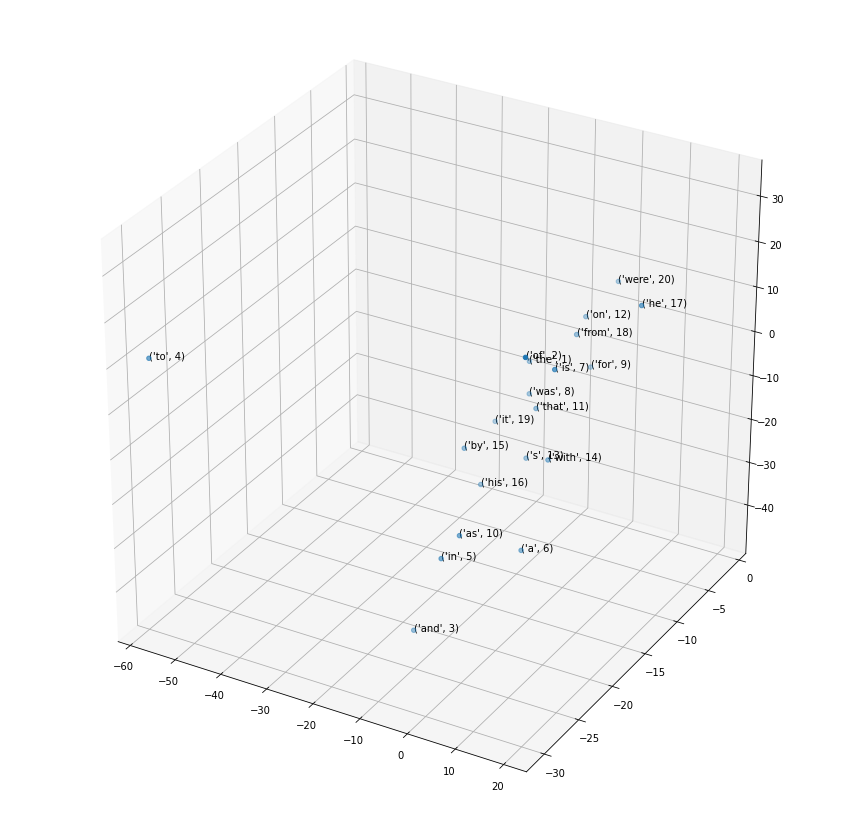

In [ ]:
#Principal Component Analysis:
from sklearn.decomposition import PCA
NUM_WORD_TO_DISPLAY = 20
pca = PCA(n_components = 3)
final_result = pca.fit_transform(embedding)
words = (tokenizer.word_index.items())
fig1 = pyplot.figure(figsize = (15, 15))
ax = pyplot.axes(projection ='3d')
ax.scatter(final_result[:NUM_WORD_TO_DISPLAY,0], final_result[:NUM_WORD_TO_DISPLAY,1], final_result[:NUM_WORD_TO_DISPLAY, 2])
for i, word in enumerate(words):
  if i==NUM_WORD_TO_DISPLAY:
    break
  ax.text(final_result[i, 0], final_result[i, 1], final_result[i, 2],  word, size=10, zorder=1,color='k')
pyplot.show()